In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Instruction
    Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
    days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user adoption.

In [23]:
user_data = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
eng_data = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
eng_data.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
eng_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Manipulation

In [24]:
user_data.rename(columns={'object_id':'user_id'}, inplace=True)
user_data.drop(columns=['name','email'], inplace=True)

In [25]:
user_data.creation_time = pd.to_datetime(user_data.creation_time)
user_data.last_session_creation_time = pd.to_datetime(user_data.last_session_creation_time,unit='s', errors='coerce')
user_data['usage_time'] = (user_data.last_session_creation_time - user_data.creation_time).dt.days

In [12]:
eng_data.time_stamp = pd.to_datetime(pd.to_datetime(eng_data.time_stamp).dt.date)
eng_data.set_index('time_stamp',inplace=True)

In [13]:
resampled_df = pd.DataFrame(eng_data.groupby('user_id').resample('7d')['visited'].sum())

In [28]:
# Define users with adopted user
adopted_user_id = resampled_df[resampled_df.visited > 2].unstack().index
user_data['invited'] = (user_data['invited_by_user_id'] > 0).astype(int)
user_data['adopted'] = user_data.user_id.apply(lambda x: 1 if x in adopted_user_id else 0)
user_data.set_index('user_id', inplace=True)

In [33]:
print('Number of Not Adopted Users {0}'.format((user_data['adopted']==0).sum()))
print('Number of Adopted Users {0}'.format((user_data['adopted']==1).sum()))

Number of Not Adopted Users 10528
Number of Adopted Users 1472


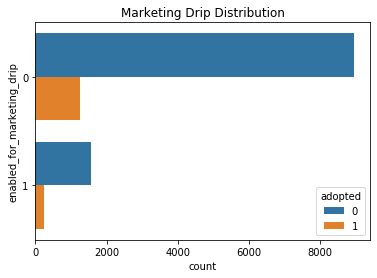

In [43]:
sns.countplot(y="enabled_for_marketing_drip", hue='adopted', data=user_data).set_title('Marketing Drip Distribution');

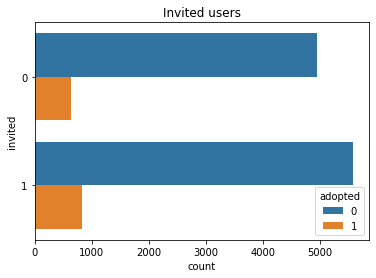

In [49]:
sns.countplot(y="invited", hue='adopted', data=user_data).set_title('Invited users')

Text(0.5, 0, 'Org_id')

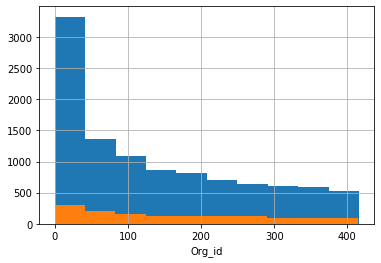

In [74]:
user_data[user_data.adopted == 0]['org_id'].hist()
user_data[user_data.adopted == 1]['org_id'].hist()
plt.xlabel('Org_id')
# Cannot find different pattern in number of adopted users and not adopted users in each organization.

In [76]:
user_data.drop(['creation_time','last_session_creation_time','org_id','invited_by_user_id'],inplace=True, axis=1)

In [97]:
print('Number of adopted users with a missing value in usage_time is {0}'.format(user_data[user_data.usage_time.isnull()]['adopted'].sum()))
# Fill in Missing values with 0 
user_data.usage_time.fillna(0, inplace=True)

Number of adopted users with a missing value in usage_time is 0


In [110]:
cat_df = pd.get_dummies(user_data.creation_source)
user_data = pd.concat([user_data.drop(columns='creation_source'),cat_df], axis=1)

In [120]:
# Top 5 features with correlating with adopted
user_data.corr()['adopted'].sort_values(ascending=False)[1:6]

usage_time            0.816581
GUEST_INVITE          0.044059
SIGNUP_GOOGLE_AUTH    0.037450
invited               0.024877
SIGNUP                0.012730
Name: adopted, dtype: float64

In [123]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = user_data.drop(columns='adopted')  #independent columns
y = user_data['adopted']    #target column i.e indicator of adopted user

# apply SelectKBest class to extract top 8 best features
# Used chi2 as score function since our input and output are categorical variable
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(8,'Score'))  

                      Specs         Score
2                usage_time  2.933534e+06
6         PERSONAL_PROJECTS  5.816122e+01
4              GUEST_INVITE  1.909586e+01
8        SIGNUP_GOOGLE_AUTH  1.488757e+01
3                   invited  3.455177e+00
7                    SIGNUP  1.606385e+00
0  opted_in_to_mailing_list  9.762665e-01
5                ORG_INVITE  6.939396e-01



    'Usage Time' and 'Creation Source' are important factors to predict future user adoption